# Train a 3D U-Net for Brain Tumor Segmentation on Intel Xeons in AWS

TensorFlow 2.9 code to train a 3D U-Net on the brain tumor segmentation ([BraTS](https://www.med.upenn.edu/sbia/brats2017.html)) subset of the [Medical Segmentation Decathlon dataset](http://medicaldecathlon.com/) dataset. 

This model can achieve a [Dice coefficient](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1415224/) of > 0.80 on the whole tumor using just the [FLAIR](https://en.wikipedia.org/wiki/Fluid-attenuated_inversion_recovery) channel.

In [1]:
# import gdown

In [2]:
# # a file
# url = "https://drive.google.com/file/d/1BSmGx4IDEqebiU2WhKsy2Td6GjTlZfPV/view?usp=sharing"
# output = "./data/Task01_BrainTumour.tar"
# gdown.download(url, output, quiet=False, fuzzy=True)


In [3]:
# !tar -C ./data -xf ./data/Task01_BrainTumour.tar

In [4]:
import tensorflow as tf
from tensorflow import keras as K

import nibabel as nib
import numpy as np
import os
import datetime
import json
    
import matplotlib.pyplot as plt

#import warnings
#warnings.filterwarnings("ignore")

%matplotlib inline

2022-09-08 20:38:06.300179: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


## Determine if we are using Intel-optimized TensorFlow (DNNL)

In [5]:
def get_mkl_enabled_flag():

    mkl_enabled = False
    major_version = int(tf.__version__.split(".")[0])
    minor_version = int(tf.__version__.split(".")[1])
    if major_version >= 2:
        if minor_version < 5:
            from tensorflow.python import _pywrap_util_port
        elif minor_version >= 9:

            from tensorflow.python.util import _pywrap_util_port
            onednn_enabled = int(os.environ.get('TF_ENABLE_ONEDNN_OPTS', '1'))

        else:
            from tensorflow.python.util import _pywrap_util_port
            onednn_enabled = int(os.environ.get('TF_ENABLE_ONEDNN_OPTS', '0'))
        mkl_enabled = _pywrap_util_port.IsMklEnabled() or (onednn_enabled == 1)
    else:
        mkl_enabled = tf.pywrap_tensorflow.IsMklEnabled()
    return mkl_enabled

print ("We are using Tensorflow version", tf.__version__)
print("MKL enabled :", get_mkl_enabled_flag())

We are using Tensorflow version 2.9.1
MKL enabled : True


In [6]:
!pwd

/home/ubuntu/brats_2018_on_intel/notebooks


In [7]:
#!cd /home/ubuntu/unet/data/ && tar -xf Task01_BrainTumour.tar

As we can see in the file directory that we just unpacked, there are multiple folders of images and a file named "dataset.json" that we'll take a look at first

In [8]:
json_filename = "/home/ubuntu/brats_2018_on_intel/data/processed/Task01_BrainTumour/dataset.json"

with open(json_filename, 'r') as f:
    data = json.load(f)

In [9]:
#data

In [10]:
data_path = "/home/ubuntu/brats_2018_on_intel/data/processed/Task01_BrainTumour/"

In [11]:
with open(json_filename, "r") as datafile:
    experiment_data = json.load(datafile)

output_channels = experiment_data["labels"]
input_channels = experiment_data["modality"]
description = experiment_data["description"]
name = experiment_data["name"]
release = experiment_data["release"]
license = experiment_data["licence"]
reference = experiment_data["reference"]
tensor_image_size = experiment_data["tensorImageSize"]
num_files = experiment_data["numTraining"]

"""
Create a dictionary of tuples with image filename and label filename
"""

filenames = {}
for idx in range(num_files):
    filenames[idx] = [os.path.join(data_path,
                                      experiment_data["training"][idx]["image"]),
                            os.path.join(data_path,
                                      experiment_data["training"][idx]["label"])]



"""
Print the dataset information
"""

print("="*30)
print("Dataset name:        ", name)
print("Dataset description: ", description)
print("Tensor image size:   ", tensor_image_size)
print("Dataset release:     ", release)
print("Dataset reference:   ", reference)
print("Input channels:      ", input_channels)
print("Output labels:       ", output_channels)
print("Dataset license:     ", license)
print("="*30)

Dataset name:         BRATS
Dataset description:  Gliomas segmentation tumour and oedema in on brain images
Tensor image size:    4D
Dataset release:      2.0 04/05/2018
Dataset reference:    https://www.med.upenn.edu/sbia/brats2017.html
Input channels:       {'0': 'FLAIR', '1': 'T1w', '2': 't1gd', '3': 'T2w'}
Output labels:        {'0': 'background', '1': 'edema', '2': 'non-enhancing tumor', '3': 'enhancing tumour'}
Dataset license:      CC-BY-SA 4.0


Let's use one file to dive into....

In [12]:
FILE_PATH="/home/ubuntu/brats_2018_on_intel/data/processed/Task01_BrainTumour/imagesTr/BRATS_001.nii.gz"

In [13]:
def read_nifti_file(filepath):
    """Read and load header and volume"""
    # Read file
    scan = nib.load(filepath)
    # Get raw data
    header = scan.header
    scan = scan.get_fdata()
    return header, scan

*** Write something short and sweet about the NIFTI File format and what to look for in the header for this example, link to more detailed information ***

In [13]:
header, scan_data = read_nifti_file(FILE_PATH)
print(header)

<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b'r'
dim_info        : 0
dim             : [  4 240 240 155   4   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : float32
bitpix          : 32
slice_start     : 0
pixdim          : [1. 1. 1. 1. 1. 0. 0. 0.]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 10
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 0
glmin           : 0
descrip         : b'5.0.10'
aux_file        : b'none'
qform_code      : scanner
sform_code      : scanner
quatern_b       : 0.0
quatern_c       : 0.0
quatern_d       : 0.0
qoffset_x       : 0.0
qoffset_y       : 0.0
qoffset_z       : 0.0
srow_x          : [1. 0. 0. 0.]
srow_y     

In [14]:
scan_data.shape

(240, 240, 155, 4)

In [15]:
print(np.min(scan_data))
print(np.max(scan_data))

0.0
2239.0


As we can see here, the values range from 0 to 2239, versus the expected ___ to ____.

Let's check the distribution of these values to see what the range and window is for this scan dataset. 

In [16]:
values = scan_data.flatten()
print(len(values))

35712000


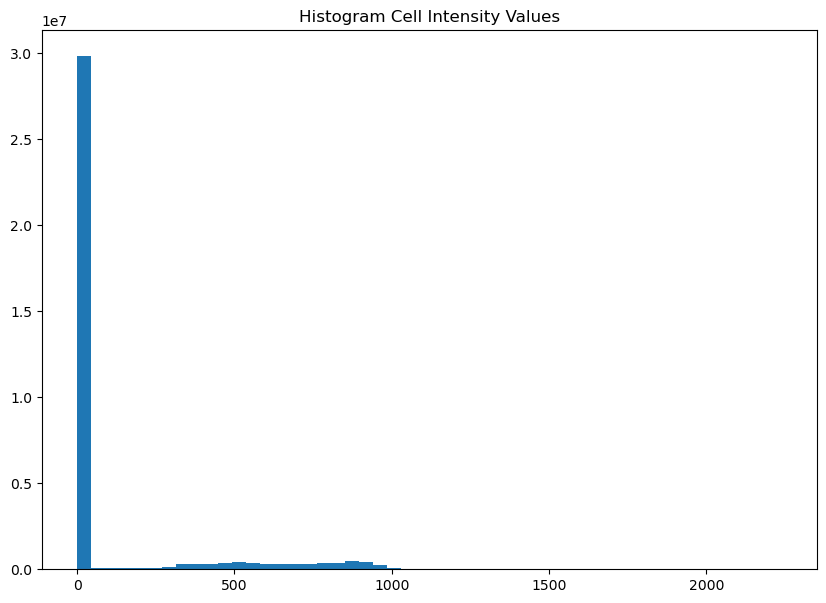

In [17]:
fig = plt.figure(figsize =(10, 7))
plt.hist(values, bins=50)
plt.title("Histogram Cell Intensity Values")
plt.show()

The large number of 0 values in the data set is expected since it is the parts of the scan that are not the brain. Let's remove the 0 values from the histogram to get a better look at our distribution. 

In [18]:
newvalues = [x for x in values if x != 0]
print(len(newvalues))

5954040


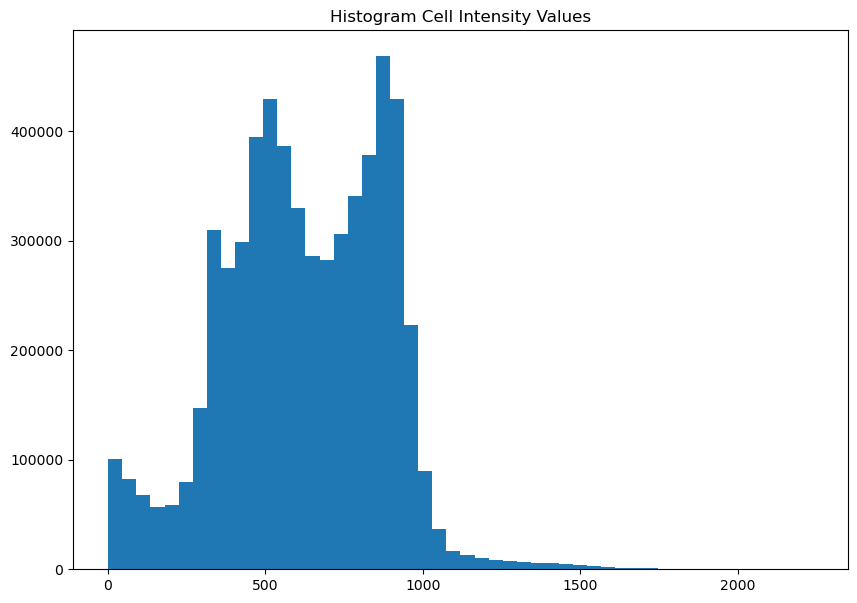

In [19]:
fig = plt.figure(figsize =(10, 7))
plt.hist(newvalues, bins=50)
plt.title("Histogram Cell Intensity Values")
plt.show()


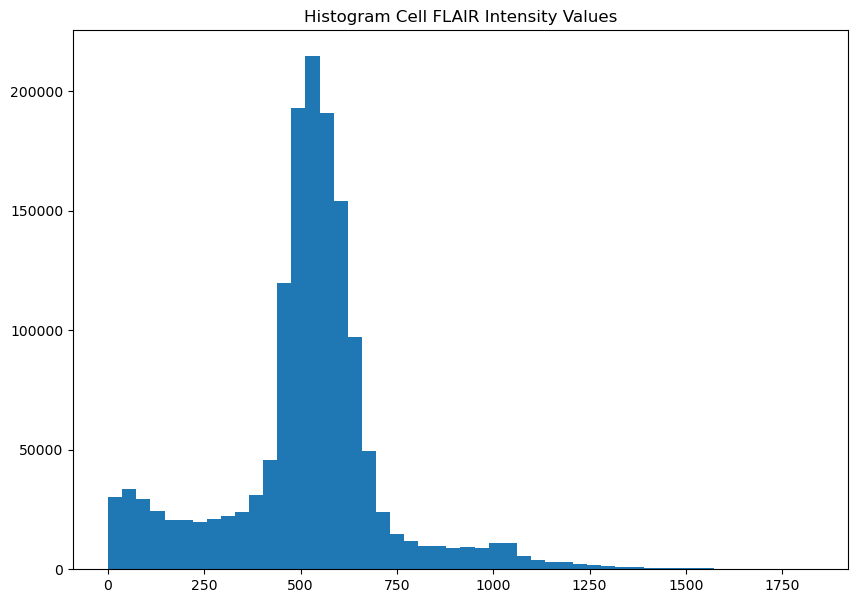

In [20]:
#Input channels:       {'0': 'FLAIR', '1': 'T1w', '2': 't1gd', '3': 'T2w'}
CHANNEL = 0
values_0 = scan_data[:,:,:,CHANNEL].flatten()
newvalues_0 = [x for x in values_0 if x != 0]

fig = plt.figure(figsize =(10, 7))
plt.hist(newvalues_0, bins=50)
plt.title("Histogram Cell FLAIR Intensity Values")
plt.show()


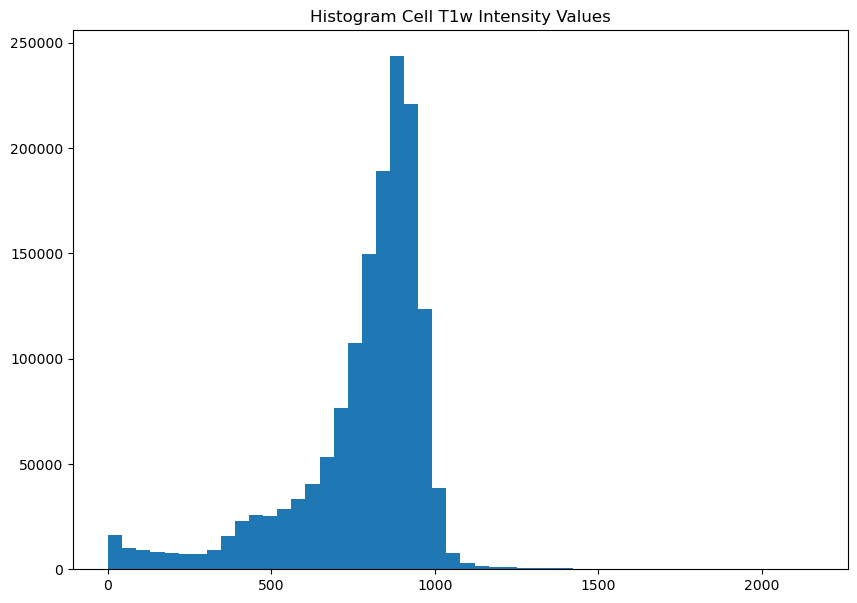

In [21]:
#Input channels:       {'0': 'FLAIR', '1': 'T1w', '2': 't1gd', '3': 'T2w'}
CHANNEL = 1
values_0 = scan_data[:,:,:,CHANNEL].flatten()
newvalues_0 = [x for x in values_0 if x != 0]

fig = plt.figure(figsize =(10, 7))
plt.hist(newvalues_0, bins=50)
plt.title("Histogram Cell T1w Intensity Values")
plt.show()


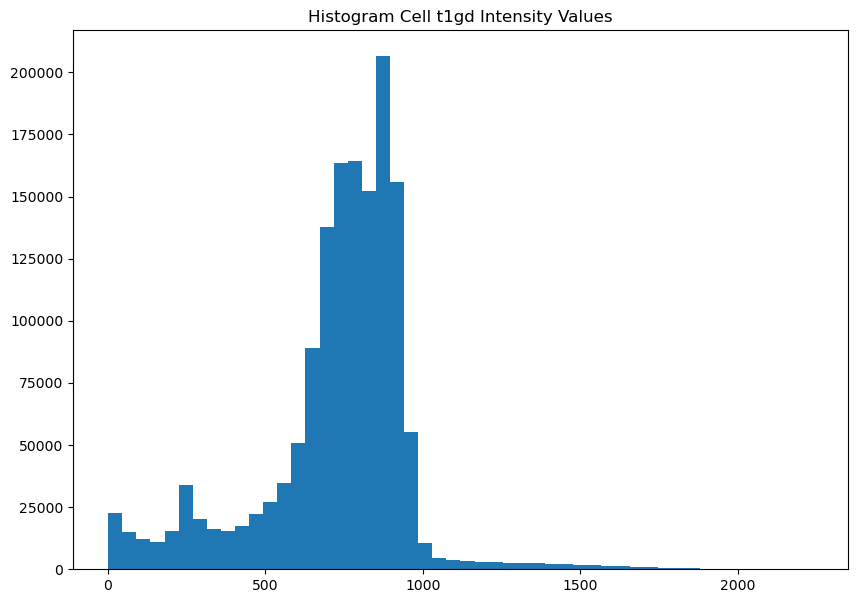

In [22]:
#Input channels:       {'0': 'FLAIR', '1': 'T1w', '2': 't1gd', '3': 'T2w'}
CHANNEL = 2
values_0 = scan_data[:,:,:,CHANNEL].flatten()
newvalues_0 = [x for x in values_0 if x != 0]

fig = plt.figure(figsize =(10, 7))
plt.hist(newvalues_0, bins=50)
plt.title("Histogram Cell t1gd Intensity Values")
plt.show()


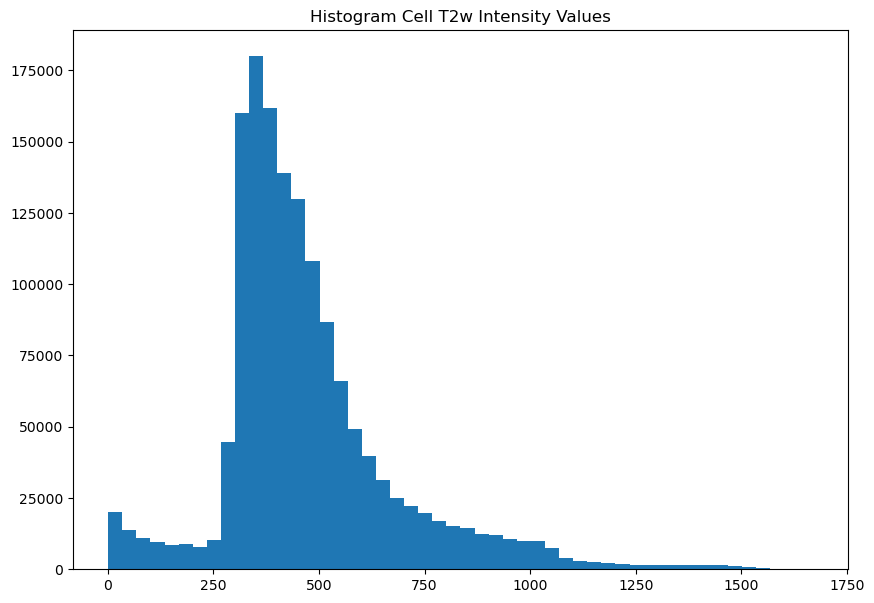

In [23]:
#Input channels:       {'0': 'FLAIR', '1': 'T1w', '2': 't1gd', '3': 'T2w'}
CHANNEL = 3
values_0 = scan_data[:,:,:,CHANNEL].flatten()
newvalues_0 = [x for x in values_0 if x != 0]

fig = plt.figure(figsize =(10, 7))
plt.hist(newvalues_0, bins=50)
plt.title("Histogram Cell T2w Intensity Values")
plt.show()


The distribution of cell intensity values gives us an idea of what an appropriate range and window could be if we want to narrow our focus within the scan. 

Now lets take a quick look at the datasets labels. 

In [24]:
LABEL_FILE_PATH="/home/ubuntu/brats_2018_on_intel/data/processed/Task01_BrainTumour/labelsTr/BRATS_001.nii.gz"

In [25]:
label_header, label_scan_data = read_nifti_file(LABEL_FILE_PATH)
print(label_header)

<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b'r'
dim_info        : 0
dim             : [  3 240 240 155   1   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : uint8
bitpix          : 8
slice_start     : 0
pixdim          : [1. 1. 1. 1. 1. 0. 0. 0.]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 10
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 0
glmin           : 0
descrip         : b'5.0.10'
aux_file        : b'none'
qform_code      : scanner
sform_code      : scanner
quatern_b       : 0.0
quatern_c       : 0.0
quatern_d       : 0.0
qoffset_x       : 0.0
qoffset_y       : 0.0
qoffset_z       : 0.0
srow_x          : [1. 0. 0. 0.]
srow_y        

In [26]:
test = nib.load(LABEL_FILE_PATH)
test.affine

array([[1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.]])

In [27]:
label_scan_data.shape

(240, 240, 155)

In [28]:
print(np.min(label_scan_data))
print(np.max(label_scan_data))

0.0
3.0


In [29]:
values = label_scan_data.flatten()
print(len(values))

8928000


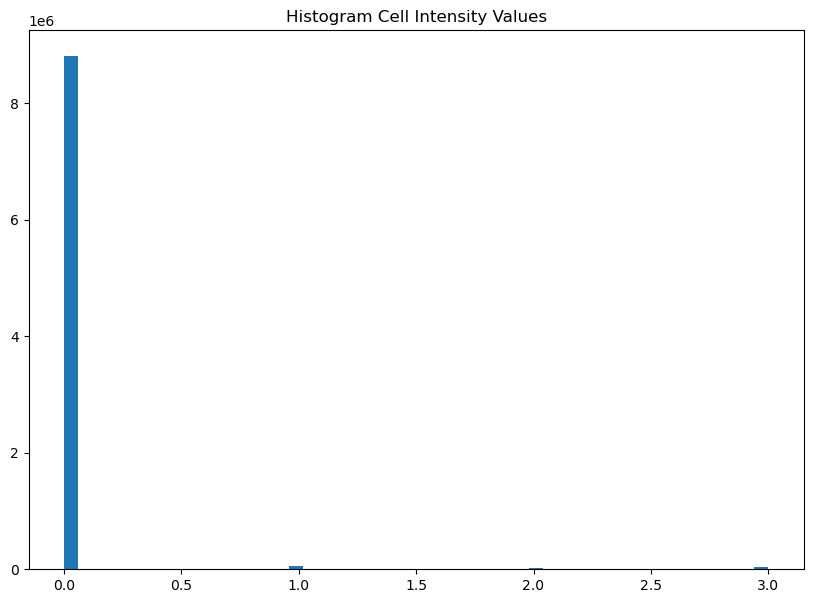

In [30]:
fig = plt.figure(figsize =(10, 7))
plt.hist(values, bins=50)
plt.title("Histogram Cell Intensity Values")
plt.show()

In [31]:
newvalues = [x for x in values if x != 0]
print(len(newvalues))

111724


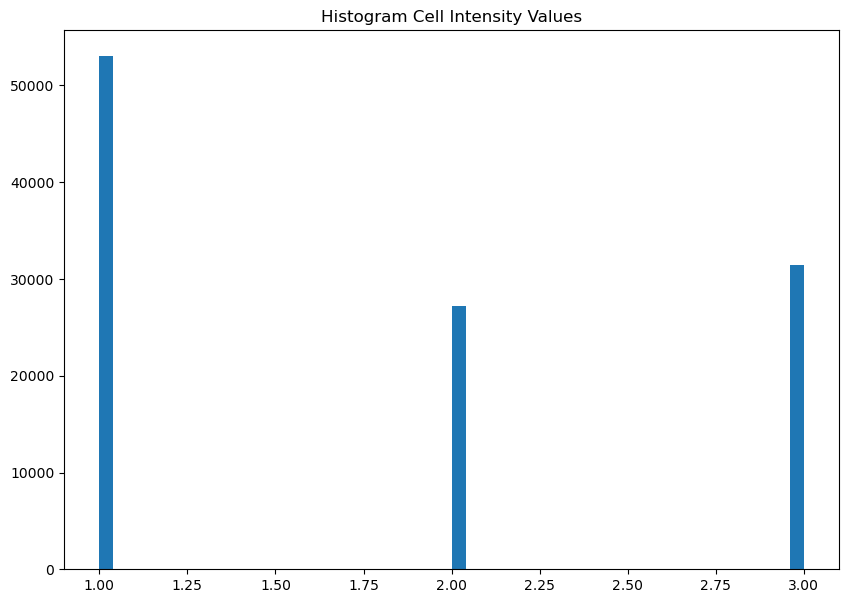

In [32]:
fig = plt.figure(figsize =(10, 7))
plt.hist(newvalues, bins=50)
plt.title("Histogram Cell Intensity Values")
plt.show()
#Output labels:        {'0': 'background', '1': 'edema', '2': 'non-enhancing tumor', '3': 'enhancing tumour'}

Should add a part to look through all scans in the dataset now that we understand one scan. Compare same distributions, check if all have a tumor, and verify image sizes or any other critical information.

In [33]:
def normalize(volume):
    """Normalize the volume"""
    min = -1000
    max = 400
    volume[volume < min] = min
    volume[volume > max] = max
    volume = (volume - min) / (max - min)
    volume = volume.astype("float32")
    return volume

In [34]:
def resize_volume(img):
    """Resize across z-axis"""
    # Set the desired depth
    desired_depth = 64
    desired_width = 128
    desired_height = 128
    # Get current depth
    current_depth = img.shape[-1]
    current_width = img.shape[0]
    current_height = img.shape[1]
    # Compute depth factor
    depth = current_depth / desired_depth
    width = current_width / desired_width
    height = current_height / desired_height
    depth_factor = 1 / depth
    width_factor = 1 / width
    height_factor = 1 / height
    # Rotate
    img = ndimage.rotate(img, 90, reshape=False)
    # Resize across z-axis
    img = ndimage.zoom(img, (width_factor, height_factor, depth_factor), order=1)
    return img

In [35]:
def process_scan(path):
    """Read and resize volume"""
    # Read scan
    _, volume = read_nifti_file(path)
    # Normalize
    #volume = normalize(volume)
    # Resize width, height and depth
    #volume = resize_volume(volume)
    return volume

In [36]:
def display_views(medical_image, channel=0):
    channels = {'0': 'FLAIR', '1': 'T1w', '2': 't1gd', '3': 'T2w'}
    
    sagital_mid = int(medical_image.shape[0] / 2) # Axis 0
    coronal_mid = int(medical_image.shape[1] / 2) # Axis 1
    axial_mid = int(medical_image.shape[2] / 2) # Axis 2
    
    sagital_image = medical_image[sagital_mid, :, :, channel] # Axis 0
    coronal_image = medical_image[:, coronal_mid, :, channel] # Axis 1
    axial_image = medical_image[:, :, axial_mid, channel] # Axis 2

    plt.figure(figsize=(20, 10))
    
    plt.subplot(1,3,1)
    plt.imshow(np.rot90(sagital_image), cmap='gray')
    plt.title('Sagital Plane')
    plt.axis('off')

    plt.subplot(1,3,2)
    plt.imshow(np.rot90(axial_image), cmap='gray')
    plt.title('Axial Plane')
    plt.axis('off')

    plt.subplot(1,3,3)
    plt.imshow(np.rot90(coronal_image), cmap='gray')
    plt.title('Coronal Plane')
    plt.axis('off')
    
    channel_name = channels[str(channel)]
    plt.suptitle(f'Modality: {channel_name}')
    plt.show()

In [37]:
def show_slice(scan_slice, level=None, window=None):
    """
    Function to display an image slice
    Input is a numpy 2D array
    """
    if (level != None) & (window != None):
        max = level + window/2
        min = level - window/2
        scan_slice = scan_slice.clip(min,max)
    else:
        scan_slice = scan_slice
    plt.figure()
    plt.imshow(scan_slice.T, cmap="gray", origin="lower")
    plt.xlabel('First axis')
    plt.ylabel('Second axis')
    plt.colorbar(label='Signal intensity')
    plt.show()
    #plt.savefig('L'+str(level)+'W'+str(window))

In [38]:
def show_slice_color(scan_slice, level=None, window=None):
    """
    Function to display an image slice
    Input is a numpy 2D array
    """
    if (level != None) & (window != None):
        max = level + window/2
        min = level - window/2
        scan_slice = scan_slice.clip(min,max)
    else:
        scan_slice = scan_slice
    plt.figure()
    plt.imshow(scan_slice.T, origin="lower")
    plt.xlabel('First axis')
    plt.ylabel('Second axis')
    plt.colorbar(label='Signal intensity')
    plt.show()
    #plt.savefig('L'+str(level)+'W'+str(window))

In [39]:
mid_scan = int(scan_data.shape[2] / 2)
scan_slice = scan_data[:,:,mid_scan,0]

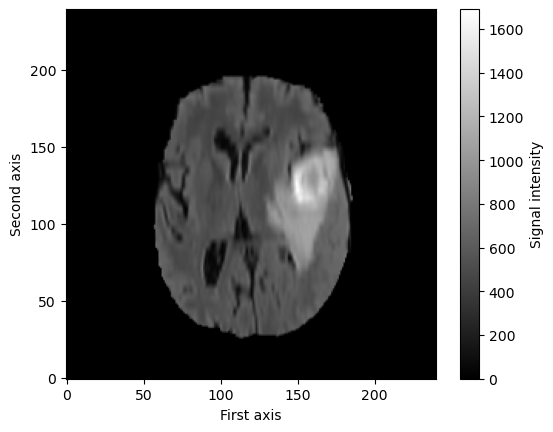

In [40]:
%matplotlib inline
show_slice(scan_slice)

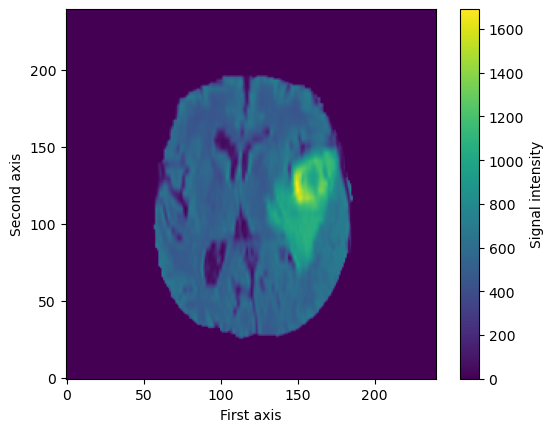

In [41]:
%matplotlib inline
show_slice_color(scan_slice)

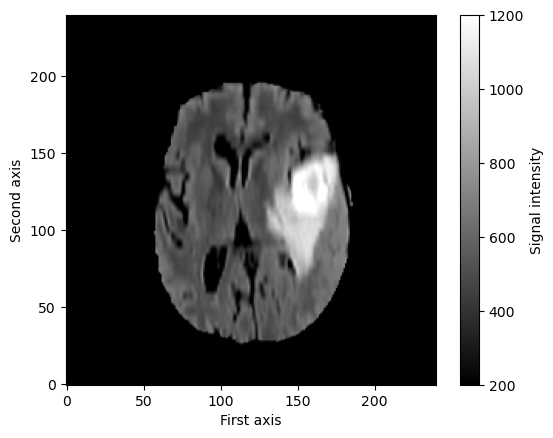

In [42]:
%matplotlib inline
show_slice(scan_slice,700,1000)

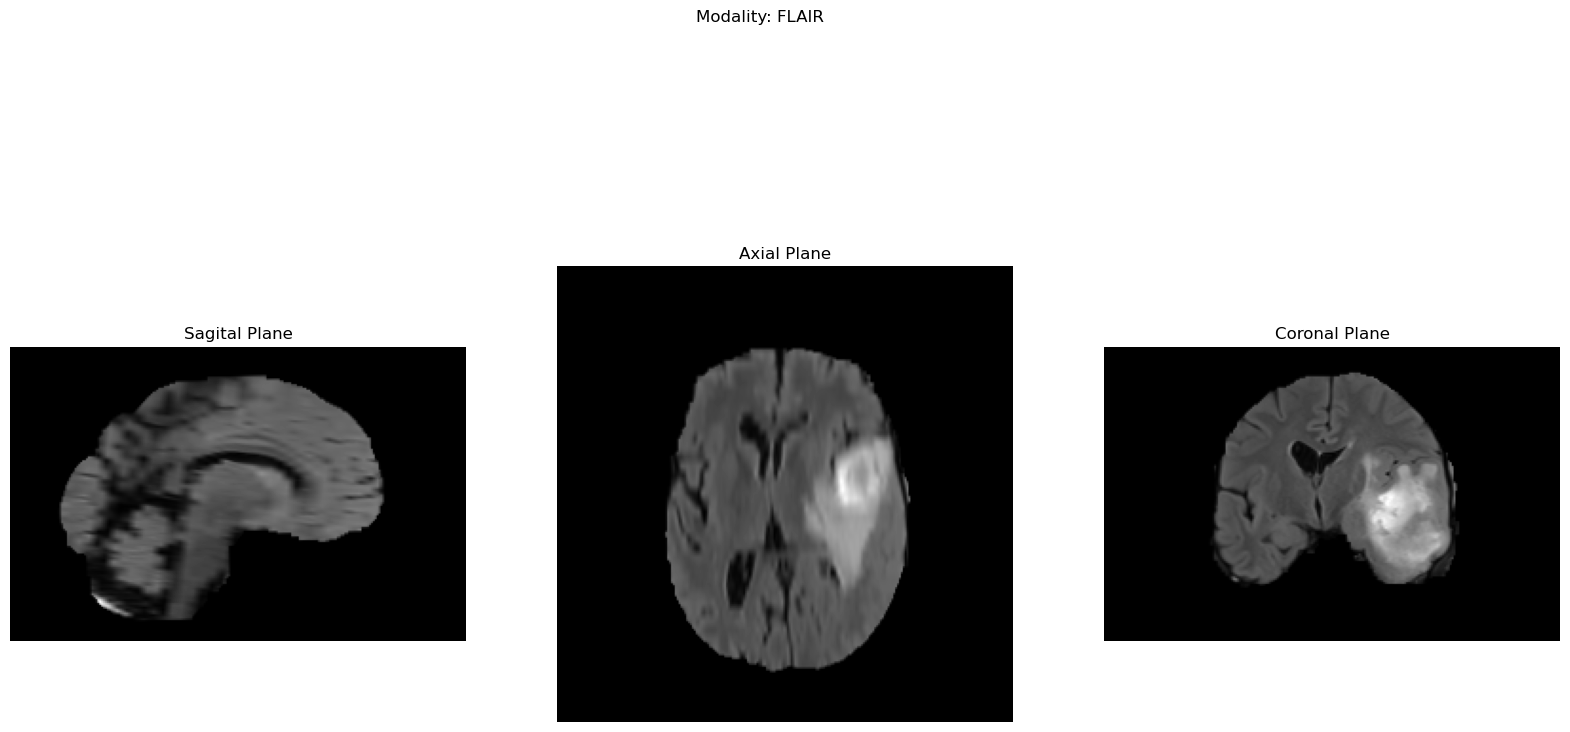

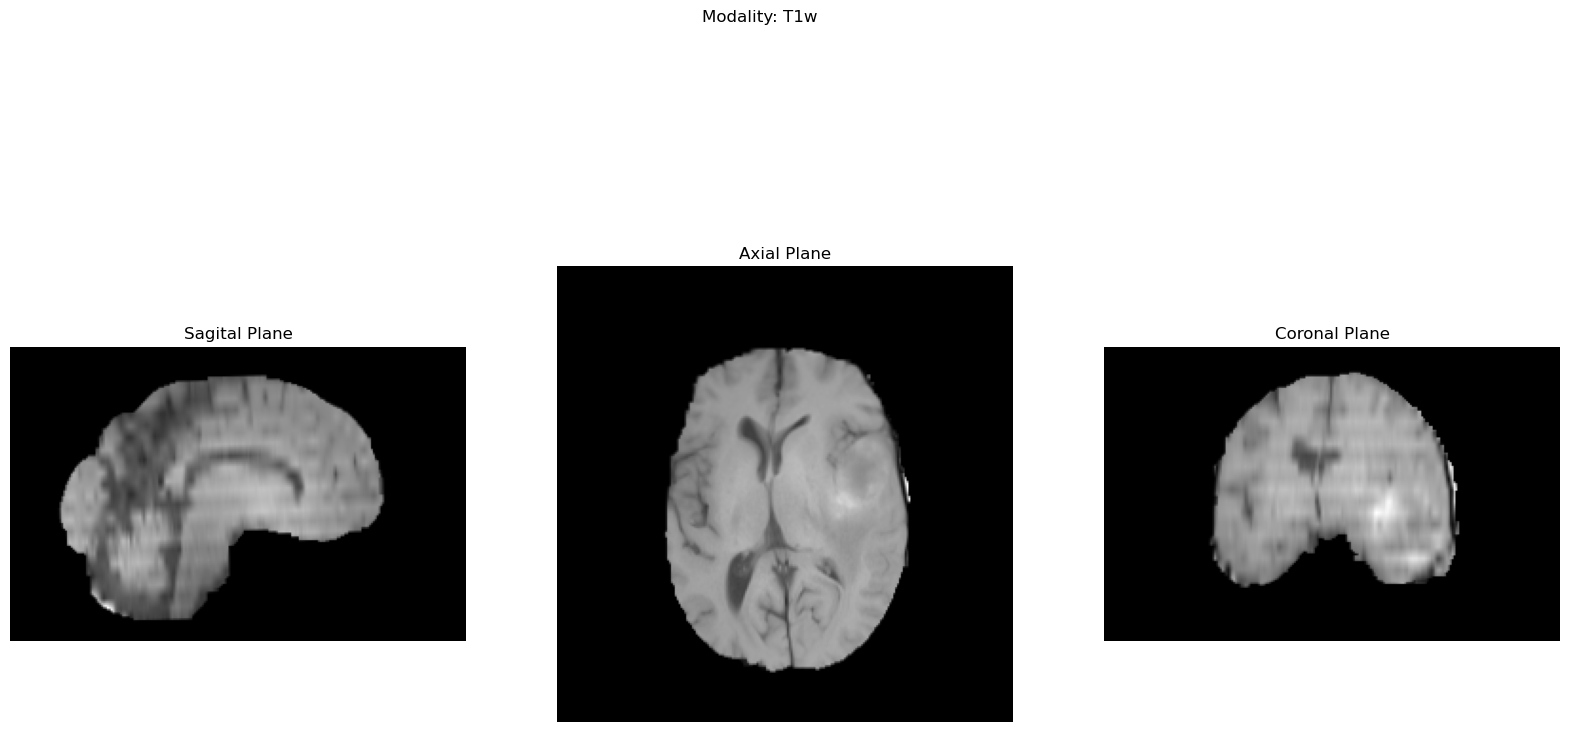

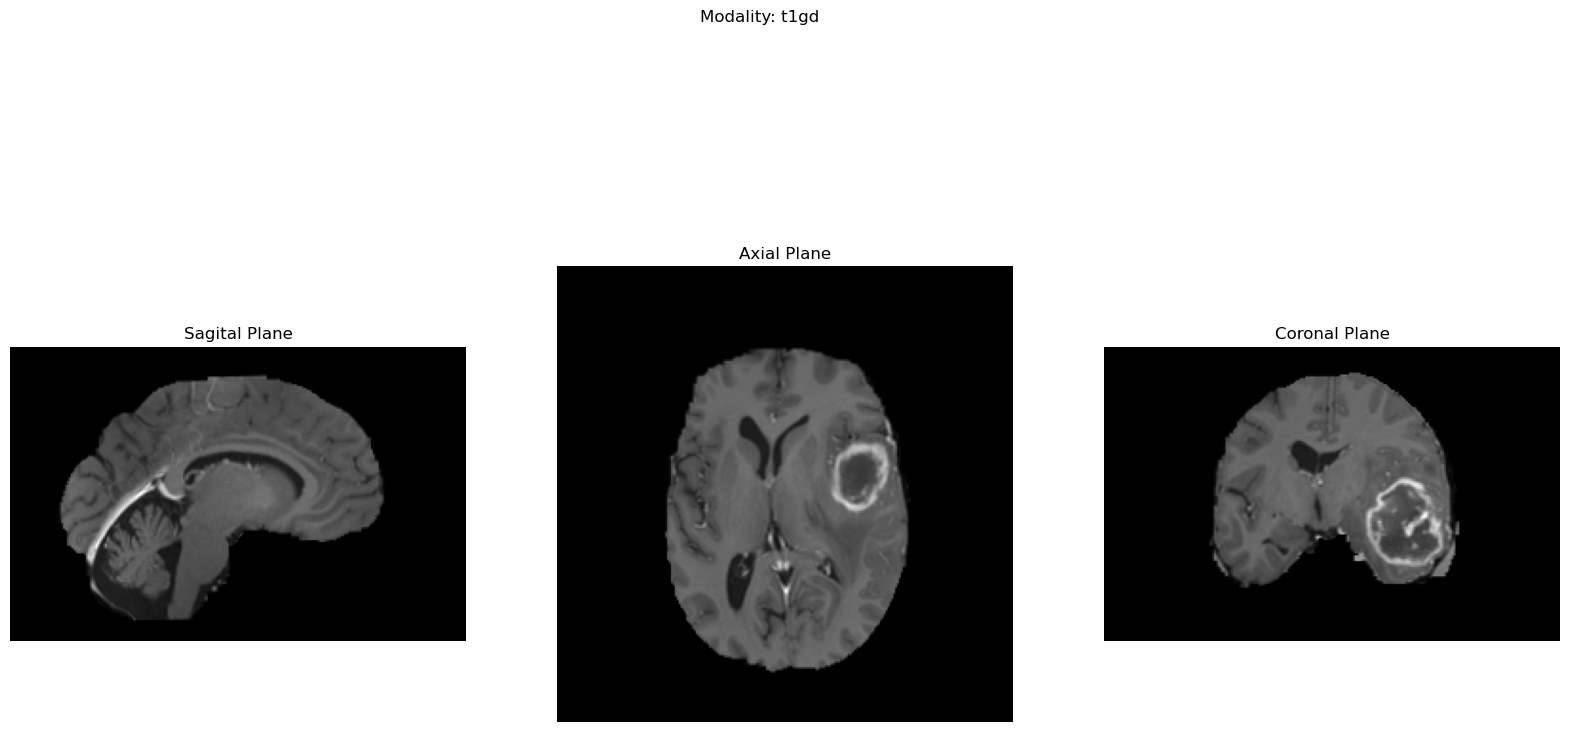

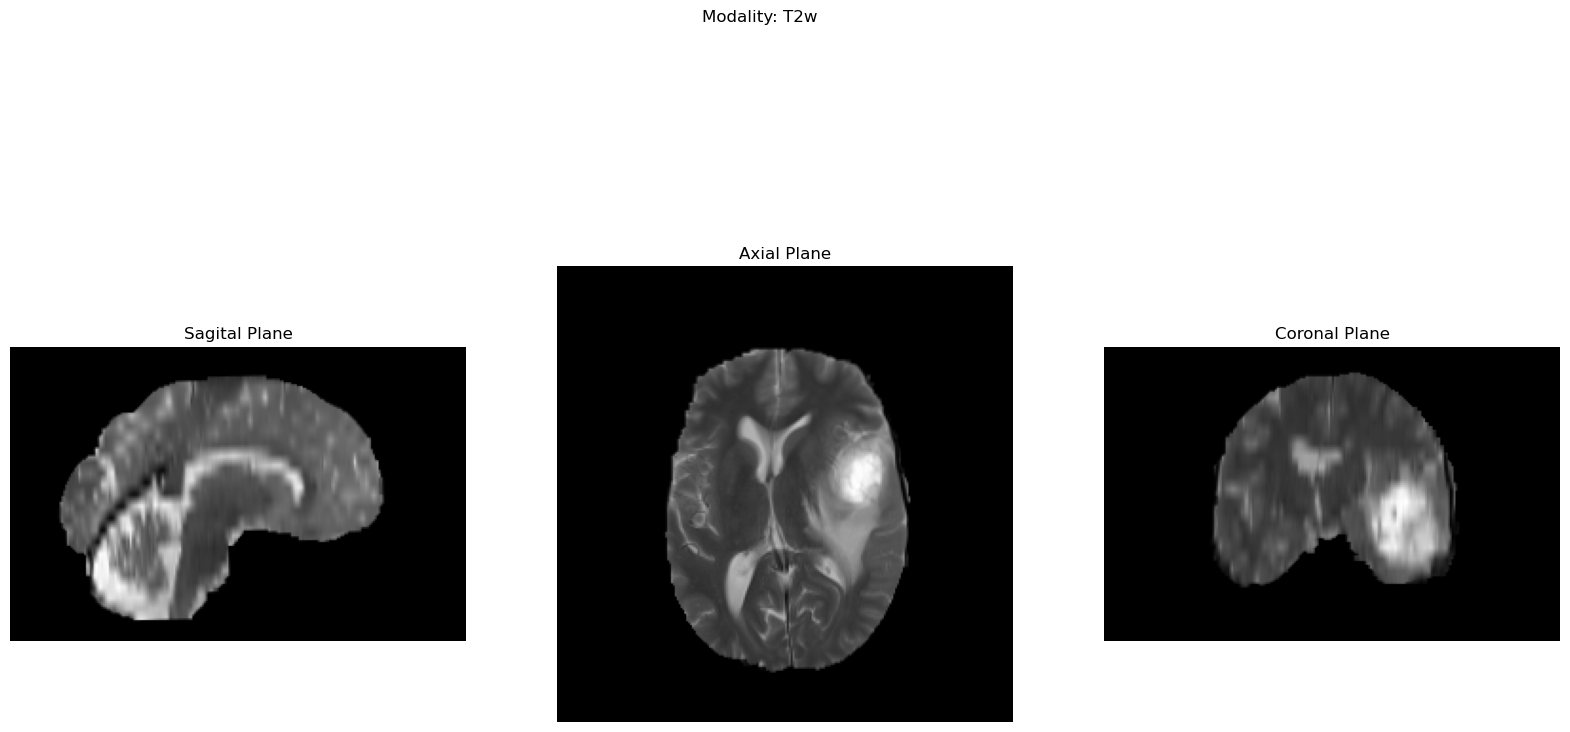

In [43]:
%matplotlib inline
medical_scan = process_scan(FILE_PATH)

for i in range(medical_scan.shape[3]):
    display_views(medical_scan, i)

### Axial Slices

In [44]:
def plot_axial_slices(scan, channel=0, center_slice=None, fig_width=12, num_rows=5, num_columns=5, img_width=None, img_height=None):
    """Plot a montage of Axial View CT slices"""
    scan = scan[:, :, :, channel:channel+1]
    
    if center_slice == None:
        center_slice = int(scan.shape[2] / 2)
    first_slice = int(center_slice - np.floor((num_rows * num_columns) / 2))
    if first_slice < 0:
        first_slice = 0
    last_slice = first_slice + (num_rows * num_columns)
    
    scan = scan[:, :, first_slice:last_slice]
    
    img_width = scan.shape[0]
    img_height = scan.shape[1]
    
    
    #scan = np.rot90(np.array(scan))
    scan = np.transpose(scan)
    scan = np.reshape(scan, (num_rows, num_columns, img_width, img_height))
    rows_data, columns_data = scan.shape[0], scan.shape[1]
    heights = [each_slice[0].shape[0] for each_slice in scan] # slice is a python function...
    widths = [each_slice.shape[1] for each_slice in scan[0]]
    fig_width = fig_width
    fig_height = fig_width * sum(heights) / sum(widths)
    f, axarr = plt.subplots(
        rows_data,
        columns_data,
        figsize=(fig_width, fig_height),
        gridspec_kw={"height_ratios": heights},
    )
    for i in range(rows_data):
        for j in range(columns_data):
            axarr[i, j].imshow(scan[i][j], cmap="gray")
            axarr[i, j].axis("off")
    plt.subplots_adjust(wspace=0, hspace=0, left=0, right=1, bottom=0, top=1)
    plt.show()


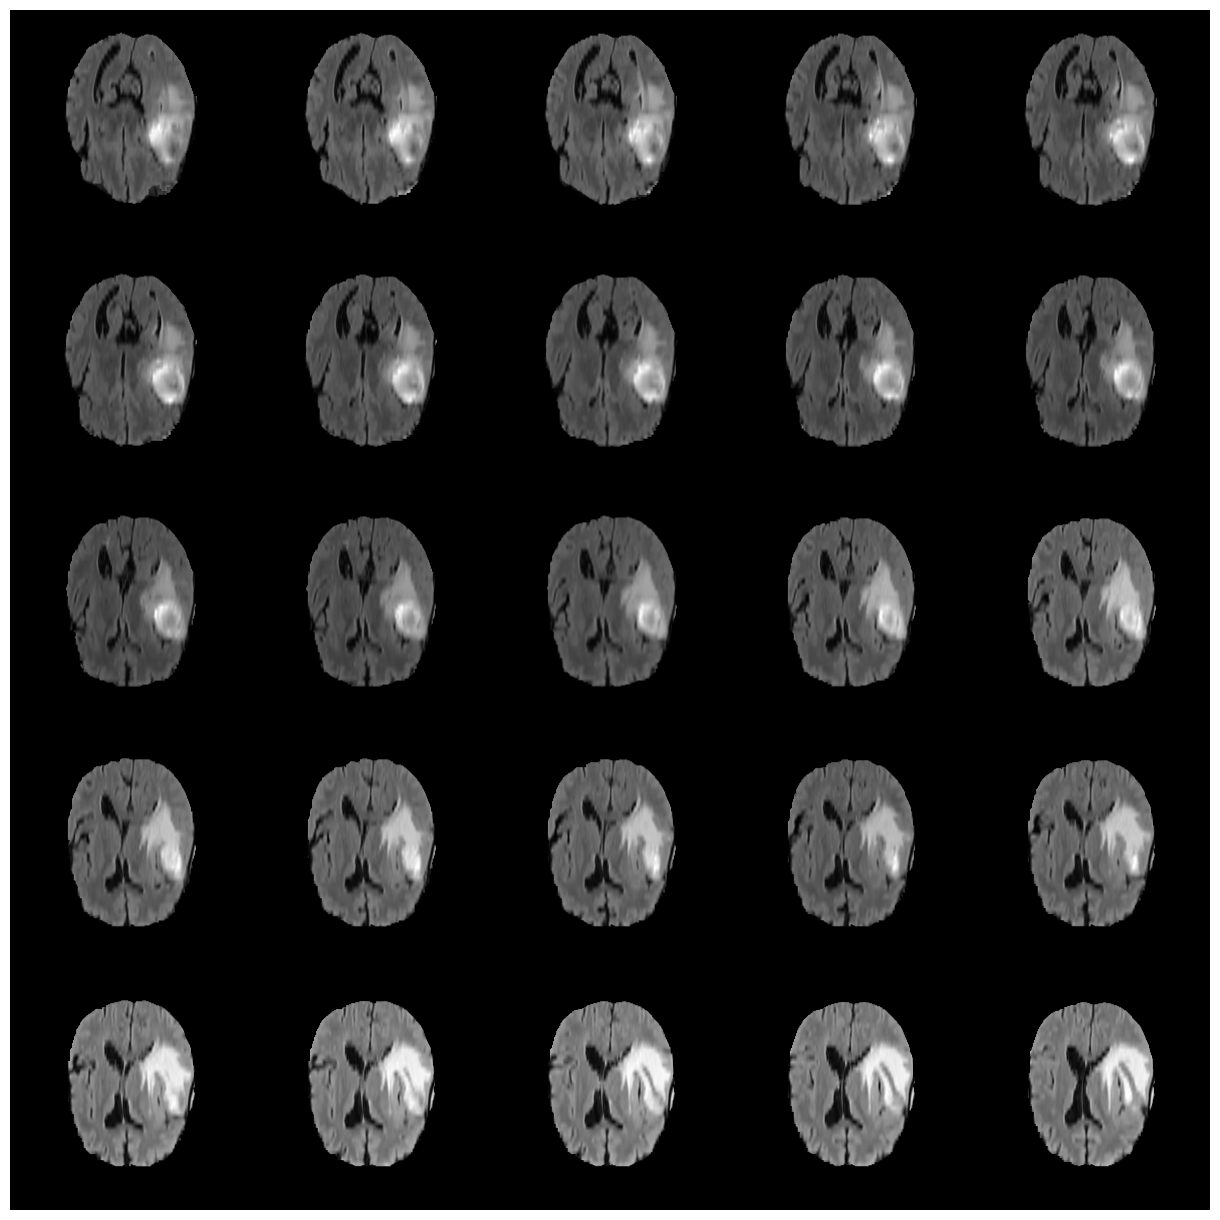

In [45]:
%matplotlib inline
plot_axial_slices(medical_scan)

In [46]:
from ipywidgets import AppLayout, IntSlider, Layout, HBox
import ipywidgets as widgets


def plot_interactive_axial_slices(scan, channel=0):
    scan = scan[:, :, :, channel]
    max_scan = scan.shape[2]
    mid_scan = int(max_scan / 2)
    
    plt.ioff()
    fig, ax = plt.subplots(1, 1, figsize=(8, 6))
    plt.ion()
    im = ax.imshow(np.rot90(scan[:, :, mid_scan]), cmap='gray')
    
    fig.canvas.header_visible = False
    #fig.canvas.layout.min_height = '400px'
    fig.canvas.toolbar_visible = False
    plt.title('Axial View Slice n.')
    
    def update(change):
        im.set_data(np.rot90(scan[:, :, change['new']]))
        fig.canvas.draw_idle()

    slider = widgets.IntSlider(orientation='vertical', \
        description='Slice #:', value=mid_scan, min=0, max=max_scan)

    slider.layout.margin = '0px 0px 0px 0px'
    #slider.layout.margin = '20% 0px 20% 0px'
    slider.layout.height = '100%'
    
    slider.observe(update, names='value')
    
    viewer = HBox([slider, fig.canvas], layout=Layout(align_items='center'))

    return viewer

In [47]:
%matplotlib widget
viewer = plot_interactive_axial_slices(medical_scan, 0)
display(viewer)

### Sagital Slices

In [48]:
def plot_sagital_slices(scan, channel=0, center_slice=None, fig_width=12, num_rows=5, num_columns=5, img_width=None, img_height=None):
    """Plot a montage of Sagital View CT slices"""
    import matplotlib.pyplot as plt
    scan = scan[:, :, :, channel:channel+1]
    
    if center_slice == None:
        center_slice = int(scan.shape[0] / 2)
    first_slice = int(center_slice - np.floor((num_rows * num_columns) / 2))
    if first_slice < 0:
        first_slice = 0
    last_slice = first_slice + (num_rows * num_columns)
    scan = scan[first_slice:last_slice, :, :]
    
    img_width = scan.shape[1]
    img_height = scan.shape[2]
    
    scan = np.transpose(scan, axes=[3,0,1,2])
    
    scan = np.reshape(scan, (num_rows, num_columns, img_width, img_height))
    rows_data, columns_data = scan.shape[0], scan.shape[1]
    heights = [each_slice[0].shape[1] for each_slice in scan] # slice is a python function...
    widths = [each_slice.shape[0] for each_slice in scan[0]]
    fig_width = fig_width
    fig_height = fig_width * sum(heights) / sum(widths)
    f, axarr = plt.subplots(
        rows_data,
        columns_data,
        figsize=(fig_width, fig_height),
        gridspec_kw={"height_ratios": heights},
    )
    for i in range(rows_data):
        for j in range(columns_data):
            axarr[i, j].imshow(np.rot90(scan[i][j]), cmap="gray")
            axarr[i, j].axis("off")
    plt.subplots_adjust(wspace=0, hspace=0, left=0, right=1, bottom=0, top=1)
    plt.show()


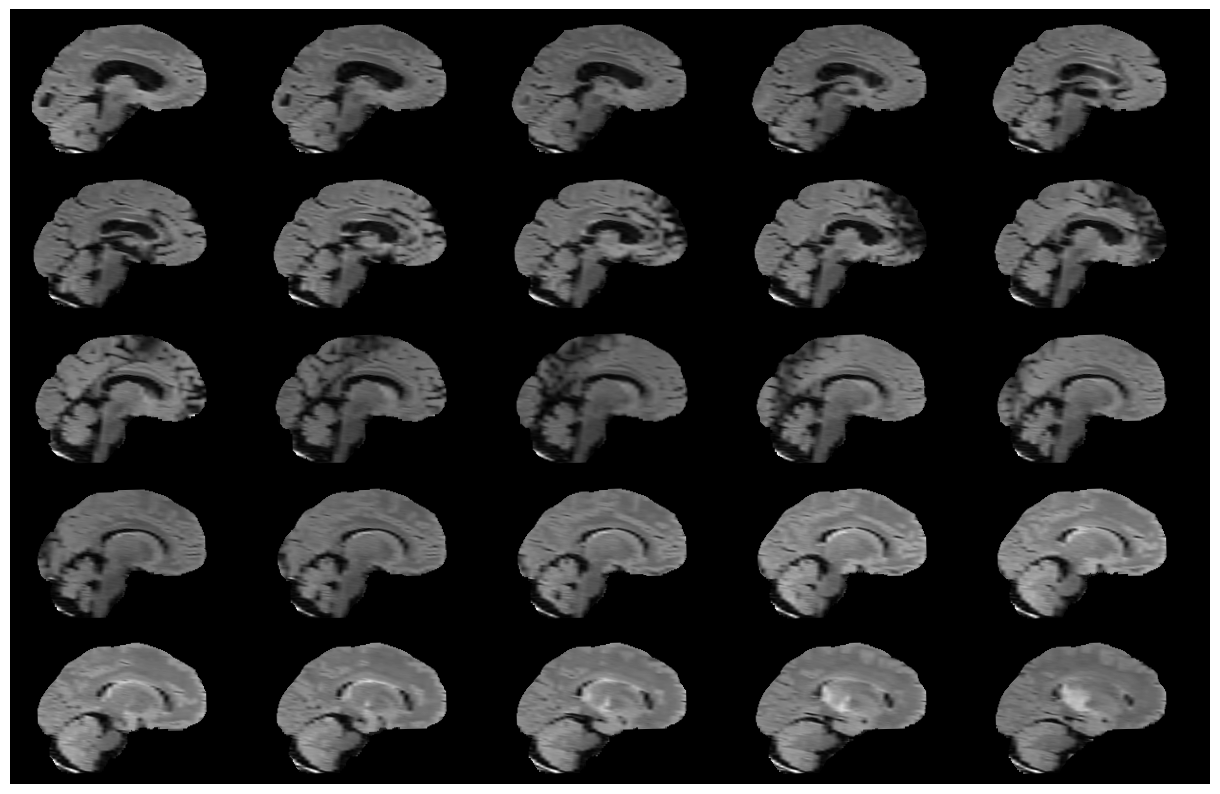

In [49]:
%matplotlib inline
plot_sagital_slices(medical_scan)

In [50]:
from ipywidgets import AppLayout, IntSlider, Layout, VBox
import ipywidgets as widgets

def plot_interactive_sagital_slices(scan, channel=0):
    scan = scan[:, :, :, channel]
    max_scan = scan.shape[0]
    mid_scan = int(max_scan / 2)
    
    plt.ioff()
    fig, ax = plt.subplots(1, 1, figsize=(8, 6))
    plt.ion()
    im = ax.imshow(np.rot90(scan[mid_scan, :, :]), cmap='gray')
    #plt.xlabel('First axis')
    #plt.ylabel('Second axis')
    #plt.colorbar(label='Signal intensity')
    
    fig.canvas.header_visible = False
    #fig.canvas.layout.min_height = '400px'
    fig.canvas.toolbar_visible = False
    plt.title('Sagital View Slice n.')
    
    def update(change):
        im.set_data(np.rot90(scan[change['new'], :, :]))
        fig.canvas.draw_idle()
  
    slider = widgets.IntSlider(orientation='horizontal', \
        description='Slice #:', value=mid_scan, min=0, max=max_scan)

    slider.layout.margin = '0px 0px 0px 0px'
    #slider.layout.margin = '20% 0px 20% 0px'
    slider.layout.width = '60%'
    
    slider.observe(update, names='value')
    
    viewer = VBox([fig.canvas,slider], layout=Layout(align_items='center'))
    
    return viewer

In [51]:
%matplotlib widget
plot_interactive_sagital_slices(medical_scan, 0)

### Coronal Slices

In [52]:
def plot_coronal_slices(scan, channel=0, center_slice=None, fig_width=12, num_rows=5, num_columns=5, img_width=None, img_height=None):
    """Plot a montage of Sagital View CT slices"""
    scan = scan[:, :, :, channel:channel+1]
    
    if center_slice == None:
        center_slice = int(scan.shape[1] / 2)
    first_slice = int(center_slice - np.floor((num_rows * num_columns) / 2))
    if first_slice < 0:
        first_slice = 0
    last_slice = first_slice + (num_rows * num_columns)
    scan = scan[:, first_slice:last_slice, :]
    
    img_width = scan.shape[0]
    img_height = scan.shape[2]
    
    scan = np.transpose(scan, axes=[3,1,0,2])
    
    scan = np.reshape(scan, (num_rows, num_columns, img_width, img_height))
    rows_data, columns_data = scan.shape[0], scan.shape[1]
    heights = [each_slice[0].shape[1] for each_slice in scan] # slice is a python function...
    widths = [each_slice.shape[0] for each_slice in scan[0]]
    fig_width = fig_width
    fig_height = fig_width * sum(heights) / sum(widths)
    f, axarr = plt.subplots(
        rows_data,
        columns_data,
        figsize=(fig_width, fig_height),
        gridspec_kw={"height_ratios": heights},
    )
    for i in range(rows_data):
        for j in range(columns_data):
            axarr[i, j].imshow(np.rot90(scan[i][j]), cmap="gray")
            axarr[i, j].axis("off")
    plt.subplots_adjust(wspace=0, hspace=0, left=0, right=1, bottom=0, top=1)
    plt.show()


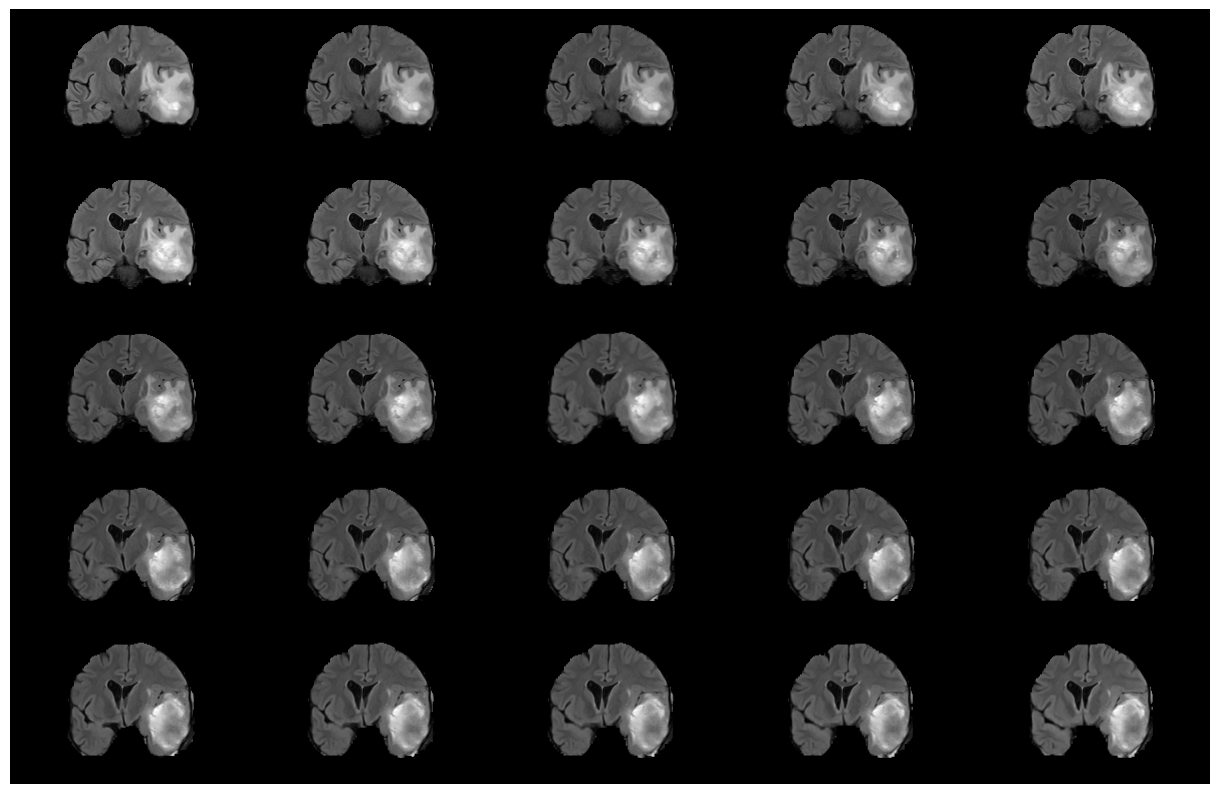

In [53]:
%matplotlib inline
plot_coronal_slices(medical_scan, num_rows=5, num_columns=5)

In [54]:
from ipywidgets import AppLayout, IntSlider, Layout, VBox
import ipywidgets as widgets


def plot_interactive_coronal_slices(scan, channel=0):
    scan = scan[:, :, :, channel]
    max_scan = scan.shape[1]
    mid_scan = int(max_scan / 2)
    
    plt.ioff()
    fig, ax = plt.subplots(1, 1, figsize=(8, 6))
    plt.ion()
    im = ax.imshow(np.rot90(scan[:, mid_scan, :]), cmap='gray')
    #plt.xlabel('First axis')
    #plt.ylabel('Second axis')
    #plt.colorbar(label='Signal intensity')
    
    fig.canvas.header_visible = False
    #fig.canvas.layout.min_height = '400px'
    fig.canvas.toolbar_visible = False
    plt.title('Coronal View Slice n.')
    
    def update(change):
        im.set_data(np.rot90(scan[:, change['new'], :]))
        fig.canvas.draw_idle()

    slider = widgets.IntSlider(orientation='horizontal', \
        description='Slice #:', value=mid_scan, min=0, max=max_scan)

    slider.layout.margin = '0px 0px 0px 0px'
    #slider.layout.margin = '20% 0px 20% 0px'
    slider.layout.width = '60%'
    
    slider.observe(update, names='value')
    
    viewer = VBox([fig.canvas,slider], layout=Layout(align_items='center'))
    
    return viewer

In [55]:
%matplotlib widget
plot_interactive_coronal_slices(medical_scan, 0)

https://ipyvolume.readthedocs.io/en/latest/

In [56]:
medical_image = nib.load(FILE_PATH)
print(medical_image.header)

<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b'r'
dim_info        : 0
dim             : [  4 240 240 155   4   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : float32
bitpix          : 32
slice_start     : 0
pixdim          : [1. 1. 1. 1. 1. 0. 0. 0.]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 10
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 0
glmin           : 0
descrip         : b'5.0.10'
aux_file        : b'none'
qform_code      : scanner
sform_code      : scanner
quatern_b       : 0.0
quatern_c       : 0.0
quatern_d       : 0.0
qoffset_x       : 0.0
qoffset_y       : 0.0
qoffset_z       : 0.0
srow_x          : [1. 0. 0. 0.]
srow_y     

In [57]:
def find_pix_dim(medical_image):
    """
    Get the pixdim of the CT image.
    A general solution that gets the pixdim indicated from the image dimensions. From the last 2 image dimensions, we get their pixel dimension.
    Args:
        ct_img: nib image

    Returns: List of the 2 pixel dimensions
    """
    pix_dim = medical_image.header["pixdim"] # example [1,2,1.5,1,1]
    dim = medical_image.header["dim"] # example [1,512,512,1,1]
    max_indx = np.argmax(dim)
    pixdimX = pix_dim[max_indx]
    dim = np.delete(dim, max_indx)
    pix_dim = np.delete(pix_dim, max_indx)
    max_indy = np.argmax(dim)
    pixdimY = pix_dim[max_indy]
    return [pixdimX, pixdimY] # example [2, 1.5]

In [58]:
find_pix_dim(medical_image)

[1.0, 1.0]